## DATA PROCESSING

Clean and prepare the 'fraud_train' and 'fraud_test.csv' files from the Sparkov Simulated Transactions Dataset

### Inspect initial rows

First I'll look import both the 'fraudTrain.csv' and 'fraudTest.csv' files, join them together and look at the first 5 rows to see the column names, the data types, and any obvious issues

In [44]:
#import libraries
import pandas as pd
from pathlib import Path

#create variable for path to files
RAW = Path("../data/raw/sparkov")

#read both files
train = pd.read_csv(RAW/"fraudTrain.csv", nrows=2500)
test  = pd.read_csv(RAW/"fraudTest.csv",  nrows=2500)

#concatonate the files and print first 5 rows
#ignore index so we dont get duplicate indexes (as both files start with index 0)
sample = pd.concat([train, test], ignore_index=True)
sample.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [45]:
#get datatypes for each column
display(sample.dtypes)
#check if any of the values in the data are NULL
display(sample.isna().sum())

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [46]:
#get count of each merchant category
sample['category'].value_counts()

category
home              563
kids_pets         503
shopping_pos      450
personal_care     415
health_fitness    389
gas_transport     388
food_dining       387
grocery_pos       368
shopping_net      367
entertainment     358
misc_pos          296
misc_net          200
travel            174
grocery_net       142
Name: count, dtype: int64

### Takeaways

 - Categories ending in '_net', e.g. 'shopping_net', clearly indicate online transactions (card-not-present)
 - All other categories are likely card present transactions

So we only want to keep the card present categories

In [47]:
import sys, os
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_clean_sparkov import process_sparkov

df_pos = process_sparkov()

### Velocity Check on Cleaned Data

check the statistics about the velocity of the cleaned data and plot the histogram as with the caixa data

In [48]:
df_pos["bucket_30s"] = df_pos["timestamp"].dt.floor("30s")
vel0 = (df_pos.groupby(["merchant_id","bucket_30s"])
       .card_id.nunique())
vel0.describe(percentiles=[.90,.95,.99])

count    1.555238e+06
mean     1.001478e+00
std      3.845280e-02
min      1.000000e+00
50%      1.000000e+00
90%      1.000000e+00
95%      1.000000e+00
99%      1.000000e+00
max      3.000000e+00
Name: card_id, dtype: float64

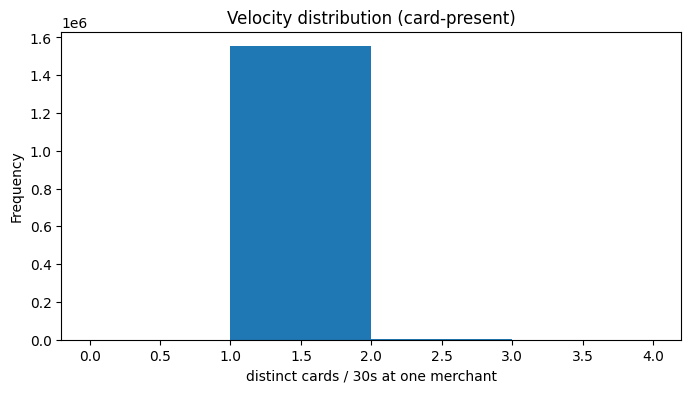

In [49]:
#draw histogram of velocity distribution
import matplotlib.pyplot as plt
vel0.plot.hist(bins=range(0, (int(vel0.max())+2)), figsize=(8,4))
plt.xlabel("distinct cards / 30s at one merchant")
plt.title("Velocity distribution (card-present)")
plt.show()

### What was learned

 - This Sparkov data showed that the 99 th percentile is ≤ 2 merchants/card
  and the maximum unique cards in a minute is 3  
 - This shows that natural card burst patterns are very rare in this
  dataset
 - Synthetic spikes will have to be added to it
 - Spikes will be added to build a baseline detector and the detector will use the Caixa data for false positive testing

### Inject Spikes and Bursts into data

Using the insert_spikes_to_data function from the inset_spike.py file, artificial merchant velocity spikes and card bursts are injected into the code. Then the velocity is retested to ensure the data will now allow a baseline detector to be made.

In [50]:
import sys, os, importlib
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from insert_spike import insert_spikes_to_data

df_spiked, truth_m, truth_c = insert_spikes_to_data(df_pos, 50, 50, 15, 30, 2, 1, 13, 7,)

PRO = Path("../data/processed")
df_spiked.to_csv(PRO / "sparkov_spikes.csv", index=False)
truth_m.to_csv(PRO / "synth_truth_merchant.csv", index=False)
truth_c.to_csv(PRO / "synth_truth_card.csv", index=False)

print("sparkov_spikes.csv rows:", len(df_spiked))
display(truth_m.head())
display(truth_c.head())

sparkov_spikes.csv rows: 1558690


,merchant_id,bucket_30s
0,fraud_Harber Inc,2019-07-12 11:29:30
1,"fraud_Bradtke, Torp and Bahringer",2019-12-06 15:26:30
2,fraud_Wisozk and Sons,2020-05-31 01:33:00
3,fraud_Nolan-Williamson,2019-09-23 23:26:30
4,fraud_Stiedemann Inc,2020-01-12 00:52:30


,card_id,burst_start
0,CBURST87831782831,2019-02-26 10:23:52
1,CBURST95181920240,2020-12-20 21:23:06
2,CBURST35766694374,2020-08-20 17:47:28
3,CBURST46785999942,2019-12-30 22:35:18
4,CBURST32345127539,2020-06-22 20:33:41


In [51]:
df_spiked["bucket_30s"] = df_spiked["timestamp"].dt.floor("30s")
vel1 = (df_spiked.groupby(["merchant_id","bucket_30s"])
       .card_id.nunique())
vel1.describe(percentiles=[.90,.95,.99])

count    1.555442e+06
mean     1.001960e+00
std      9.332439e-02
min      1.000000e+00
50%      1.000000e+00
90%      1.000000e+00
95%      1.000000e+00
99%      1.000000e+00
max      1.600000e+01
Name: card_id, dtype: float64

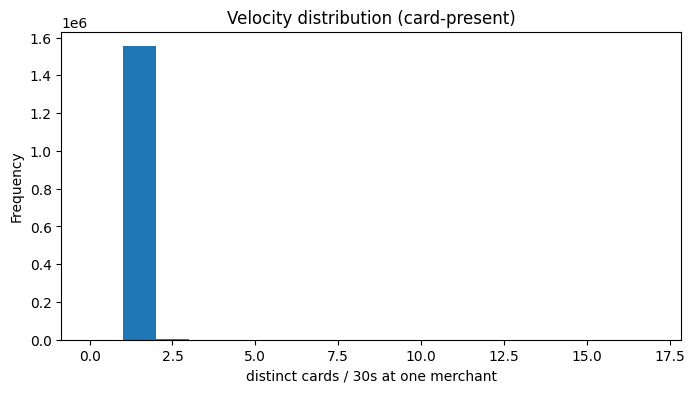

In [52]:
#draw histogram of velocity distribution
import matplotlib.pyplot as plt
vel1.plot.hist(bins=range(0, int(vel1.max()+2)), figsize=(8,4))
plt.xlabel("distinct cards / 30s at one merchant")
plt.title("Velocity distribution (card-present)")
plt.show()

### OUTCOME

Now we can see that the max distinct cards per bucket is 16, allowing us to run baseline velocity spike tests